# Choosing between shared and group-specifi expressions, given two groups' observed interactions

January 2025

In [1]:
# import jax
import numpy as np
import jax.numpy as jnp
# from jax import lax
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2

import math

import data_tools
import model_tools
import utils

from enums import *

sns.set_theme('talk')

In [2]:
data = data_tools.get_data(expt_type=ExptTypes.SharedUnique)
tangram_info = data_tools.get_tangram_info(expt_type=ExptTypes.SharedUnique)
data_organized = data_tools.make_data_matrices(data, expt_type=ExptTypes.SharedUnique)


In [3]:
for k, val in data_organized.items():
    print(k, val.shape)

(0, 'a') (12, 12, 2, 3, 10)
(0, 'b') (12, 12, 2, 3, 13)
(1, 'a') (12, 12, 2, 3, 15)
(1, 'b') (12, 12, 2, 3, 9)
(2, 'a') (12, 12, 2, 3, 7)
(2, 'b') (12, 12, 2, 3, 11)


In [4]:
tangram_info

,tangram_set,counterbalance,audience_group,shared.tangram,unique.tangram
0,0,a,Blue,B,A
1,0,a,Blue,B,D
2,0,a,Blue,B,H
3,0,a,Blue,C,A
4,0,a,Blue,C,D
...,...,...,...,...,...
103,2,b,Red,G,E
104,2,b,Red,G,K
105,2,b,Red,I,C
106,2,b,Red,I,E


In [5]:
alphas = jnp.array([1]) 
w_rs = jnp.arange(0, 20, 0.1)
w_ss = jnp.arange(0, 10, 0.1)
w_cs = jnp.array([0]) # no cost in design

In [6]:
params_list_no_social = utils.get_params_list(
    alphas=alphas, w_rs=w_rs, w_ss=jnp.array([0]), w_cs=w_cs
)

params_list_social = utils.get_params_list(
    alphas=alphas, w_rs=w_rs, w_ss=w_ss, w_cs=w_cs
)

In [7]:
best_params_no_social, best_nll_no_social, _ = model_tools.fit_params_overall(data_organized, tangram_info, params_list=params_list_no_social, expt_type=ExptTypes.SharedUnique)
best_params_social, best_nll_social, _ = model_tools.fit_params_overall(data_organized, tangram_info, params_list=params_list_social, expt_type=ExptTypes.SharedUnique)

In [8]:
print(f"Best params no social: {best_params_no_social}")
print(f"NLL no social: {best_nll_no_social}")
print(f"Best params social: {best_params_social}")
print(f"NLL social: {best_nll_social}")

Best params no social: [1.  9.2 0.  0. ]
NLL no social: 2278.255126953125
Best params social: [1.  9.2 0.4 0. ]
NLL social: 2256.69091796875


Get model predictions (probability of later utterance)

In [9]:
preds_no_social = model_tools.get_model_preds(*best_params_no_social, expt_type=ExptTypes.SharedUnique)
preds_social = model_tools.get_model_preds(*best_params_social, expt_type=ExptTypes.SharedUnique)

Put the model predictions in a dataframe

In [10]:
# Put it in a dataframe
df_preds = pd.DataFrame(columns=["type", "condition", "p_groupspecific"])
rows = []
for condition in Conditions:
    rows.append(
        {
            "type": "no_social",
            "condition": condition.name,
            "p_groupspecific": preds_no_social[condition, 0],
        }
    )

for condition in Conditions:
    rows.append(
        {
            "type": "social",
            "condition": condition.name,
            "p_groupspecific": preds_social[condition, 0],
        }
    )

df_preds = pd.concat([df_preds, pd.DataFrame(rows)], ignore_index=True)

# remove jax stuff
df_preds["p_groupspecific"] = df_preds["p_groupspecific"].apply(lambda x: x.item())
df_preds

,type,condition,p_groupspecific
0,no_social,ReferEither,0.250051
1,no_social,ReferOne,0.500000
2,no_social,SocialOne,0.500000
3,social,ReferEither,0.250051
4,social,ReferOne,0.500000
5,social,SocialOne,0.598688


Plot

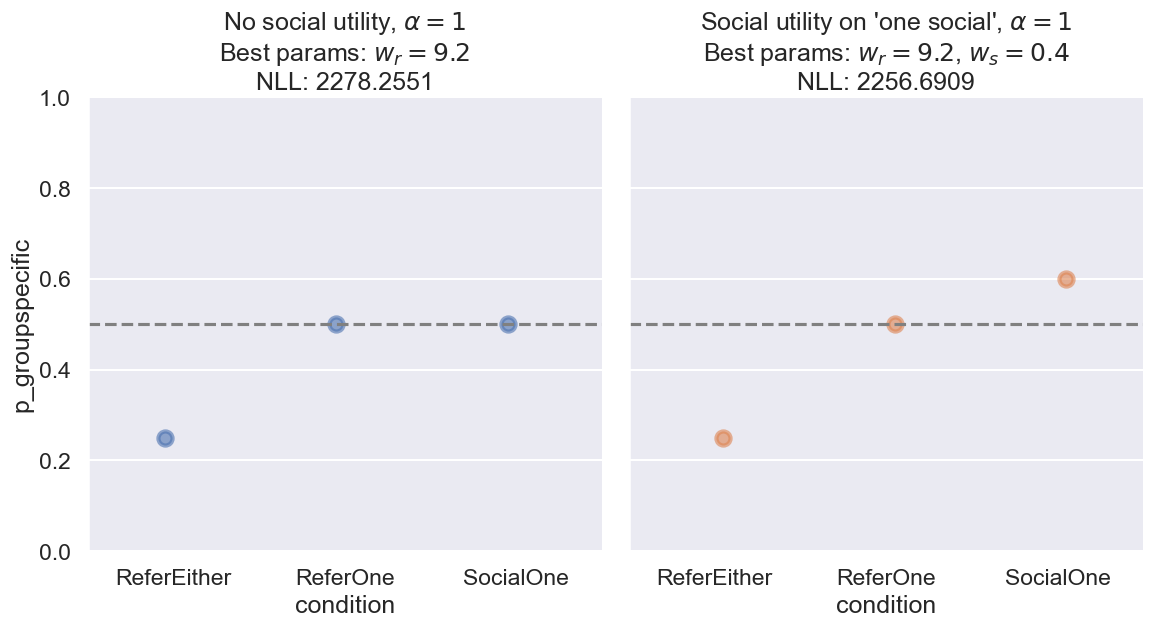

In [11]:
g = sns.catplot(
    data=df_preds,
    x="condition",
    y="p_groupspecific",
    col="type",
    kind="point",
    height=6,
    aspect=1,
    hue="type",
    dodge=0.1,
    alpha=0.6,
    linestyle="none",
    legend=False
)

g.set(ylim=(0, 1))
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")

# add an extra title to each of the plots
titles = [
    f"No social utility, $\\alpha=1$\nBest params: $w_r={best_params_no_social[1]:.1f}$\nNLL: {best_nll_no_social:.4f}",
    f"Social utility on 'one social', $\\alpha=1$\nBest params: $w_r={best_params_social[1]:.1f}$, $w_s={best_params_social[2]:.1f}$\nNLL: {best_nll_social:.4f}",
]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)  # add padding to the title

plt.show()

Do likelihood ratio test

In [12]:
# Test statistic
lr_stat = 2 * (best_nll_no_social - best_nll_social)

# Degrees of freedom: number of additional parameters in the "social" model
df = 1  # w_s is the additional parameter

p_value = chi2.sf(lr_stat, df)

print(f"Likelihood Ratio Test Statistic: {lr_stat}")
print(f"Degrees of Freedom: {df}")
print(f"P-value: {p_value}")

Likelihood Ratio Test Statistic: 43.12841796875
Degrees of Freedom: 1
P-value: 5.126224860460063e-11


## Fit separate params for each participant

In [13]:
best_params_social_pp, best_nll_social_pp, _ = model_tools.fit_params_participant(data_organized, tangram_info, params_list=params_list_social, expt_type=ExptTypes.SharedUnique)

In [14]:
# make best_params_social_pp into a dataframe
df_params = pd.DataFrame(columns=["alpha", "w_r", "w_s", "w_c"])
rows = []
for i, params in enumerate(best_params_social_pp):
    rows.append(
        {
            "alpha": params[0].item(),
            "w_r": params[1].item(),
            "w_s": params[2].item(),
            "w_c": params[3].item(),
        }
    )
df_params = pd.concat([df_params, pd.DataFrame(rows)], ignore_index=True)

/var/folders/fc/814yph2s11jgjvdqqz2x9w0c0000gn/T/ipykernel_83781/392003415.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_params = pd.concat([df_params, pd.DataFrame(rows)], ignore_index=True)


In [15]:
df_params

,alpha,w_r,w_s,w_c
0,1.0,15.800000,0.000000,0.0
1,1.0,14.100000,2.100000,0.0
2,1.0,14.000000,0.000000,0.0
3,1.0,0.000000,0.500000,0.0
4,1.0,2.800000,0.000000,0.0
...,...,...,...,...
60,1.0,14.400001,2.800000,0.0
61,1.0,16.000000,9.900001,0.0
62,1.0,1.000000,0.500000,0.0
63,1.0,0.000000,0.200000,0.0


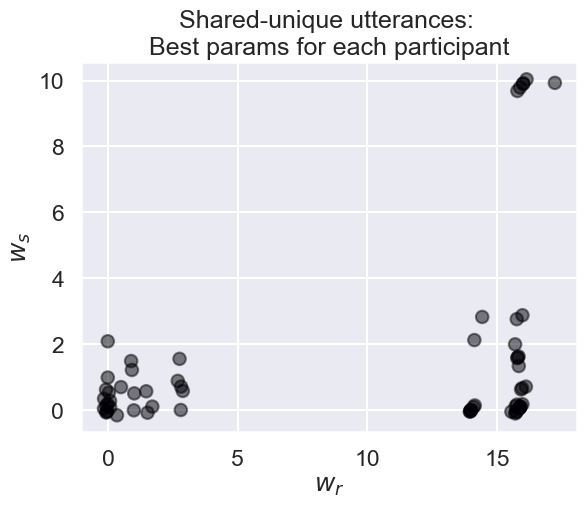

In [16]:
jitter = np.random.normal(0, 0.1, size=df_params.shape[0])
points = plt.scatter(df_params["w_r"] + jitter, df_params["w_s"] + jitter, c=df_params["w_c"], cmap="magma", alpha=0.5)
plt.xlabel("$w_r$")
plt.ylabel("$w_s$")
plt.title(f"Shared-unique utterances: \nBest params for each participant")
plt.show()

What are each of these groups? 

Filter the points, and plot the data

In [17]:
data_all = utils.make_stacked_mtx(data_organized)
data_all.shape

(12, 12, 2, 3, 65)

In [18]:
data_avg = jnp.mean(data_all, axis=(0, 1, 2)) * 16
# scale by 16 because a quarter of the first 2 dms are empty (it's shared tangram x unique tangram, 3 each, but dims are 12x12)

In [19]:
data_avg.shape

(3, 65)

First, plot all the data, as a sanity check

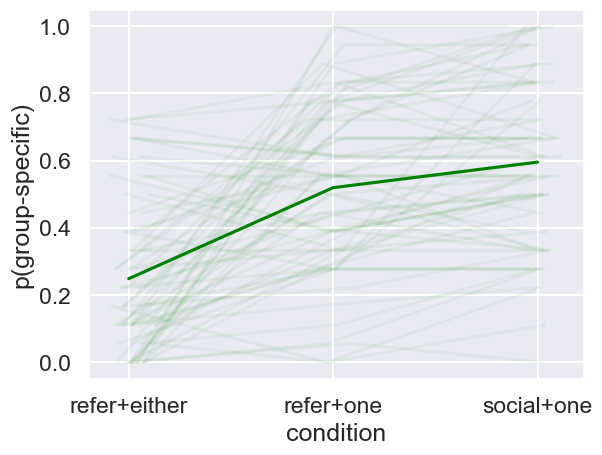

In [20]:
condition_indices = [0, 1, 2]
fig, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    jitter = np.random.normal(0, 0.05, size=len(condition_indices))
    ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

means = jnp.nanmean(data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
plt.show()

In [21]:
params_mtx = jnp.array(best_params_social_pp)

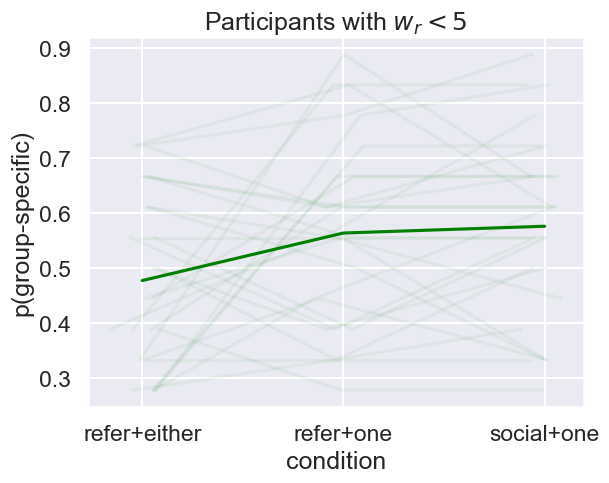

In [22]:
w_r_mask = (params_mtx[:, 1] < 5) 

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_r < 5$")
plt.show()

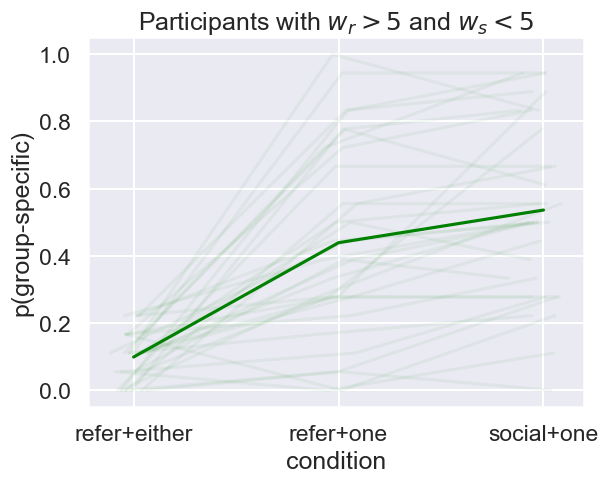

In [23]:
w_r_mask = (params_mtx[:, 1] > 5) & (params_mtx[:, 2] < 5)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_r > 5$ and $w_s < 5$")
plt.show()

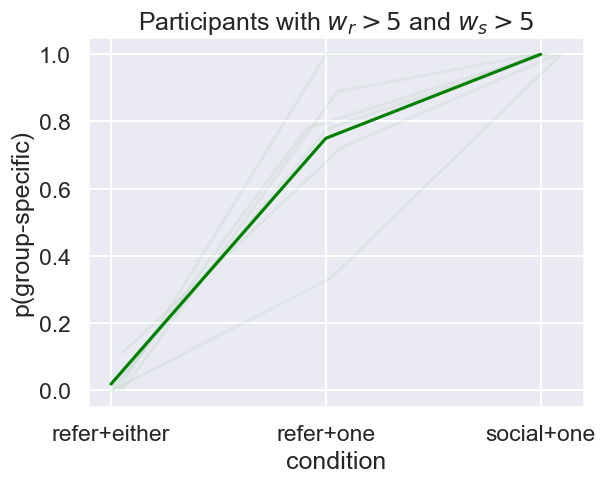

In [24]:
w_r_mask = (params_mtx[:, 1] > 5) & (params_mtx[:, 2] > 5)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_r > 5$ and $w_s > 5$")
plt.show()

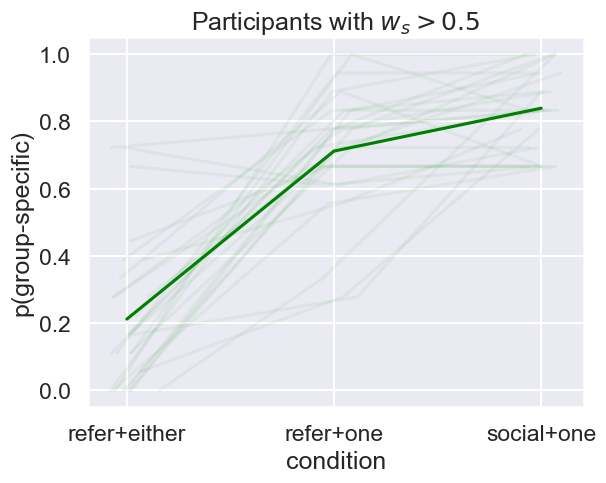

In [25]:
w_r_mask = (params_mtx[:, 2] > 0.5)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_s > 0.5$")
plt.show()

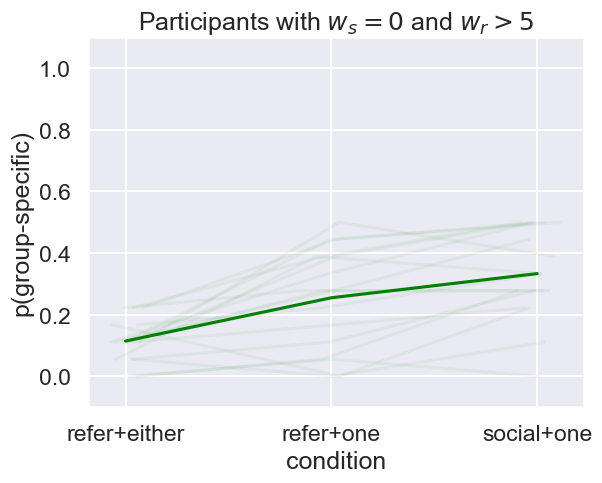

In [26]:
w_r_mask = (params_mtx[:, 2] == 0) & (params_mtx[:, 1] > 5)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set(ylim=(-0.1, 1.1))
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_s = 0$ and $w_r > 5$")
plt.show()

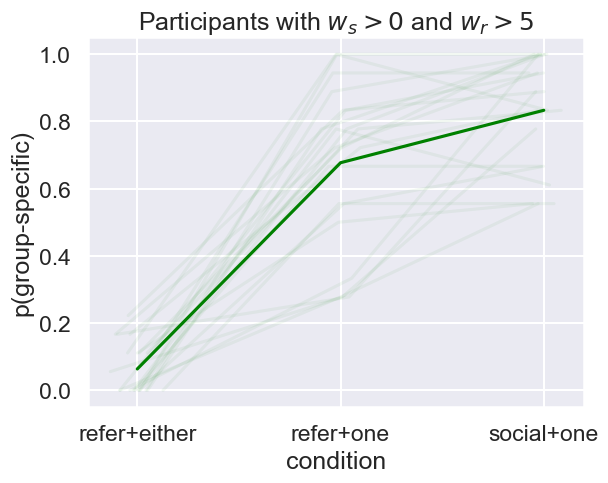

In [27]:
w_r_mask = (params_mtx[:, 2] > 0) & (params_mtx[:, 1] > 5)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_s > 0$ and $w_r > 5$")
plt.show()

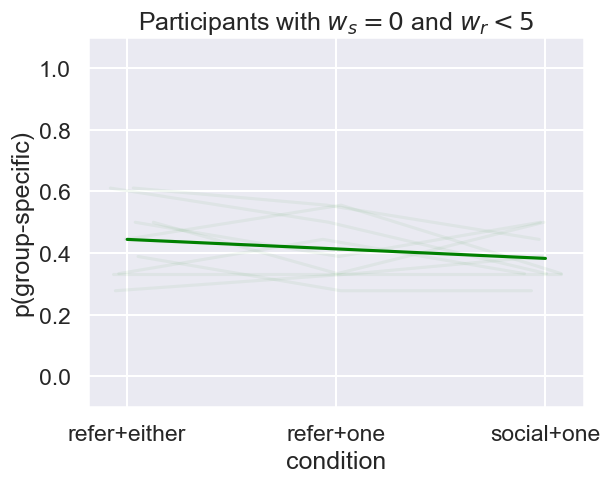

In [28]:
w_r_mask = (params_mtx[:, 2] == 0) & (params_mtx[:, 1] < 5)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set(ylim=(-0.1, 1.1))
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_s = 0$ and $w_r < 5$")
plt.show()

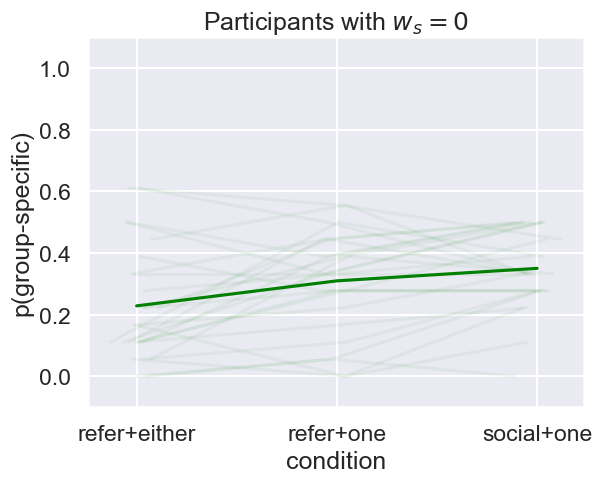

In [29]:
w_r_mask = (params_mtx[:, 2] == 0)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set(ylim=(-0.1, 1.1))
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_s= 0$")
plt.show()

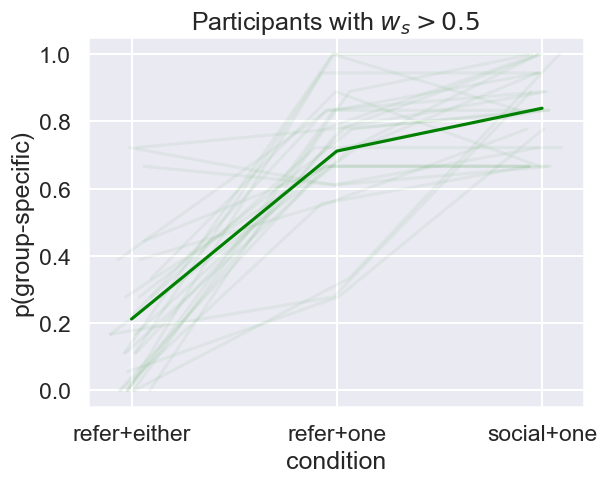

In [30]:
w_r_mask = (params_mtx[:, 2] > 0.5)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_s > 0.5$")
plt.show()

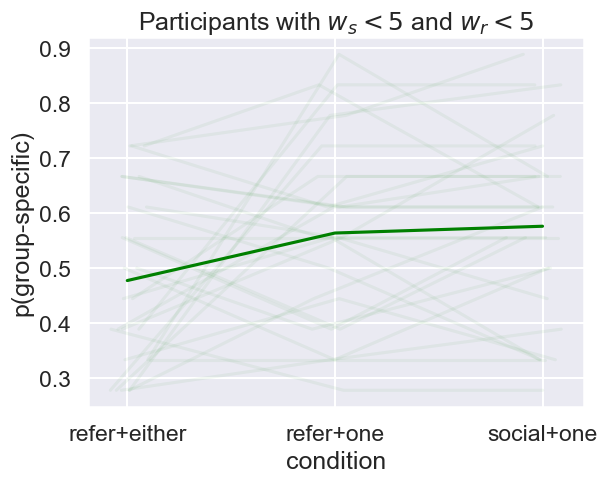

In [31]:
w_r_mask = (params_mtx[:, 2] < 5) & (params_mtx[:, 1] < 5)

# plot those
f, ax = plt.subplots()
for participant_idx in range(data_avg.shape[1]): 
    if w_r_mask[participant_idx]:
        jitter = np.random.normal(0, 0.05, size=len(condition_indices))
        ax.plot(condition_indices + jitter, data_avg[:, participant_idx], color="green", alpha=0.05)

# take mean of the masked data
masked_data_avg = data_avg[..., w_r_mask]
means = jnp.nanmean(masked_data_avg, axis=1)
ax.plot(condition_indices, means, color="green")
ax.set_xticks(condition_indices, ["refer+either", "refer+one", "social+one"])
ax.set_ylabel("p(group-specific)")
ax.set_xlabel("condition")
ax.set_title("Participants with $w_s < 5$ and $w_r < 5$")
plt.show()